In [ ]:
pip install --upgrade pip

In [ ]:
import os
import yaml

with open("environment.yml") as file_handle:
    environment_data = yaml.safe_load(file_handle)

for dependency in environment_data["dependencies"]:
    if isinstance(dependency, dict):
      for lib in dependency['pip']:
        os.system(f"pip install {lib}")

In [ ]:
!pip install transformers datasets matplotlib

In [ ]:
! pip install -q kaggle

In [ ]:
os.environ['TOKENIZERS_PARALLELISM'] = 'true' # or 'false'

In [ ]:
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Must sign up for the competition and verify your account with a text message before downloading the data

In [ ]:
! kaggle competitions download -c 'shopee-product-matching'

In [ ]:
!unzip -q -o ./shopee-product-matching.zip -d ./shopee-product-matching/

In [3]:
import numpy as np
import pandas as pd
import matplotlib

import torch
import torchvision.transforms as transforms
from torch.utils.data.dataset import Dataset
from transformers import AutoTokenizer
from tqdm import tqdm
from modules.datasets.ImageShopeeDataset import ImageShopeeDataset
from modules.datasets.TextShopeeDataset import TextShopeeDataset
from modules.models.ResNet18EmbeddingsShopeeNet import ResNet18EmbeddingsShopeeNet
from modules.models.BERTPreTrainedEmbeddingsShopeeNet import BERTPreTrainedEmbeddingsShopeeNet
import os

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator9allocatorE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [4]:
DATA_FOLDER = './shopee-product-matching/'

IS_TEST = False

def get_dataset(root=DATA_FOLDER, is_test=False):
    name = "test.csv" if is_test else "train.csv"
    df = pd.read_csv(DATA_FOLDER + name)
    images_folder = "test_images/" if is_test else "train_images/"
    df['image'] = DATA_FOLDER + images_folder + df['image']
    return df

def add_target(df):
    grouped = df.groupby('label_group')['posting_id'].apply(list)
    target = df['label_group'].map(grouped)
    new_df = df.copy()
    new_df['target'] = target
    return new_df

df = get_dataset(is_test=IS_TEST)
train = add_target(df)

In [14]:
# Prepare DataLoaders
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
text_dataset = TextShopeeDataset(train['title'].values)

def my_collate_fn(data):
    """
    data: list of input text strings
    return: dict with keys: input_ids, token_type_ids, attention_mask where each key is a tensor
    """
    
    # This probably could be optimized if we don't want to instantiate a new tokenizer each iteration.
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased") 
    inputs = tokenizer(data, padding=True, return_tensors="pt")
    return inputs
    
text_loader = torch.utils.data.DataLoader(
    text_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=4,
    collate_fn=my_collate_fn
)

In [15]:
DEVICE = 'cuda'
bert_pretrain_model = BERTPreTrainedEmbeddingsShopeeNet()
bert_pretrain_model.to(DEVICE)

text_embeddings = []
with torch.no_grad():
    for data in tqdm(text_loader):
        
        # Check if a GPU is available
        if torch.cuda.is_available():
            # Move the inputs to the GPU
            data = {name: tensor.to('cuda') for name, tensor in data.items()}
        else:
            print('GPU not available')
        
        embeddings = bert_pretrain_model(data)
        embeddings = embeddings.data.cpu().numpy()
        text_embeddings.extend(embeddings)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 268/268 [01:43<00:00,  2.59it/s]


In [7]:
text_embeddings = np.stack(text_embeddings)
norms = np.linalg.norm(text_embeddings, axis=1)
text_embeddings = text_embeddings / norms[:, np.newaxis]
text_embeddings.shape

(34250, 768)

In [8]:
np.save('./text_embeddings', text_embeddings)

In [9]:
!apt install libomp-dev
!python -m pip install --upgrade faiss-gpu==1.7.2
import faiss

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package libomp-dev
  Using cached faiss_gpu-1.7.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (85.5 MB)


In [10]:
k = 100
res = faiss.StandardGpuResources()
index_text = faiss.IndexFlatIP(text_embeddings.shape[1])
# index_img = faiss.index_cpu_to_gpu(res, 0, index_img)
index_text.add(text_embeddings)
similarities_text, indexes_text = index_text.search(text_embeddings, k)

In [11]:
def calc_f1_score(targets, results):
    intersect = len(np.intersect1d(targets, results))
    return 2 * intersect / (len(targets) + len(results))

def process_for_threshold(similarities, indexes, threshold, embeddings):
    f1_score_accumulated = 0
    for i in range(len(embeddings)):
        cur_sims = similarities[i]
        cur_indexes = indexes[i]
        duplicate_indexes = cur_indexes[cur_sims >= threshold]
        results = df.iloc[duplicate_indexes]['posting_id'].values
        targets = df.iloc[i]['target']
        f1_score = calc_f1_score(targets, results)
        f1_score_accumulated += f1_score
    return f1_score_accumulated / len(embeddings)

thresholds = np.arange(0.85, 0.99, 0.01)
f1_avg_scores = []
for threshold in tqdm(thresholds):
    f1_avg = process_for_threshold(similarities_text, indexes_text, threshold, text_embeddings)
    f1_avg_scores.append(f1_avg)

100%|██████████| 15/15 [02:33<00:00, 10.21s/it]


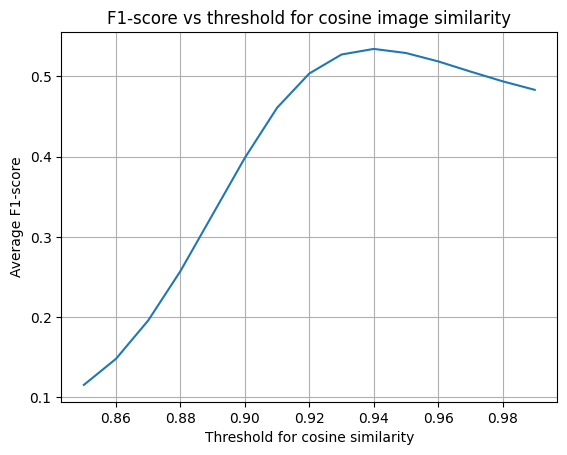

In [12]:
import matplotlib.pyplot as plt

plt.plot(thresholds, f1_avg_scores)

# Add labels and title
plt.xlabel('Threshold for cosine similarity')
plt.ylabel('Average F1-score')
plt.title('F1-score vs threshold for cosine image similarity')
plt.grid(True)

max_f1 = max(f1_avg_scores)
max_threshold = thresholds[np.argmax(f1_avg_scores)]

# plt.annotate(f"{max_f1}", xy=(max_threshold, max_f1), xytext=(max_threshold, max_f1-0.05),
#              arrowprops=dict(facecolor='black', shrink=0.2), horizontalalignment = 'center')

# Save the plot to a file
plt.savefig('cnn-baseline-thresholds.png')

In [13]:
print(f"Max f1-score: {max_f1}, threshold: {max_threshold}") 

Max f1-score: 0.5342057613037663, threshold: 0.9400000000000001
